**Installation et Importation des dépendances**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import spacy
from wordcloud import WordCloud

In [2]:
# Installer les dépendances nécessaires
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install nltk
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Téléchargement et Configuration des Ressources NLP**

In [3]:
# Télécharger les stopwords pour NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Charger le modèle de spaCy pour la lemmatisation
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Définition de la Fonction de Prétraitement**

In [4]:
# Fonction de prétraitement des textes
def preprocess_text(text):
    text = text.lower()
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]
    return ' '.join(tokens)

**Chargement et Prétraitement des Datasets**

In [5]:
# Charger les deux datasets
# Dataset 1 : Critiques de restaurants
restaurant_data = pd.read_csv('/kaggle/input/restaurant-reviews-dataset/yelp-restaurant-reviews.csv')
restaurant_data['review'] = restaurant_data['review'].apply(preprocess_text)

# Dataset 2 : Critiques de films
film_data = pd.read_csv('/kaggle/input/movie-reviews-dataset/imdb-movie-reviews.csv')
film_data['review'] = film_data['review'].apply(preprocess_text)

**Préparation des Données (Tokenisation et Séquençage)**

In [6]:
# Fonction pour préparer les données
def prepare_data(data):
    X = data['review']
    y = data['sentiment']
    tokenizer = Tokenizer(num_words=1000)
    tokenizer.fit_on_texts(X)
    X_seq = tokenizer.texts_to_sequences(X)
    X_padded = pad_sequences(X_seq, maxlen=20)
    return train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Préparer les données pour les deux datasets
X_train_rest, X_test_rest, y_train_rest, y_test_rest = prepare_data(restaurant_data)
X_train_film, X_test_film, y_train_film, y_test_film = prepare_data(film_data)

**Construction du Modèle CNN**

In [7]:
# Construire le modèle CNN
def build_model():
    model = Sequential([
        Embedding(input_dim=1000, output_dim=20, input_length=20),
        Conv1D(256, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

**Entraînement et Évaluation du Modèle**

In [8]:
# Entraîner et évaluer le modèle sur les deux datasets
def train_and_evaluate(model, X_train, X_test, y_train, y_test, dataset_name):
    print(f"Entraînement sur le dataset : {dataset_name}")
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print(classification_report(y_test, y_pred))
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Négatif", "Positif"], yticklabels=["Négatif", "Positif"])
    plt.title(f"Matrice de confusion - {dataset_name}")
    plt.show()
    
    # Courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'Courbe ROC - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    return history

**Entraînement des Modèles sur les Deux Datasets**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Entraînement sur le dataset : Restaurants
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 530ms/step - accuracy: 0.5042 - loss: 2.2499 - val_accuracy: 0.5200 - val_loss: 2.0319
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6105 - loss: 2.0158 - val_accuracy: 0.5700 - val_loss: 1.9757
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7285 - loss: 1.8192 - val_accuracy: 0.5850 - val_loss: 1.9200
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7754 - loss: 1.7382 - val_accuracy: 0.6350 - val_loss: 1.8654
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7958 - loss: 1.6022 - val_accuracy: 0.7000 - val_loss: 1.8112
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8471 - loss: 1.4712 - val_accuracy: 0.6400 - val_loss: 1.7590
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8852 - loss: 1.3576 - val_accuracy: 0.6050 - val_loss: 1.7083
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9009 - loss: 1.2753 - val_

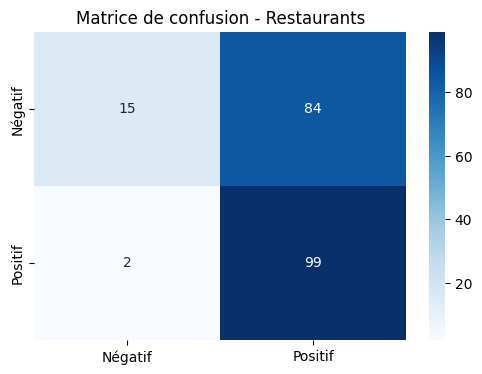

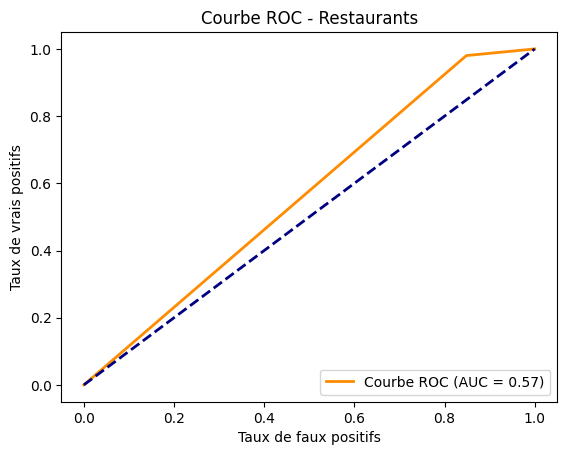

Entraînement sur le dataset : Films
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6151 - loss: 1.6432 - val_accuracy: 0.4961 - val_loss: 1.0051
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7669 - loss: 0.6711 - val_accuracy: 0.6986 - val_loss: 0.6324
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7796 - loss: 0.5308 - val_accuracy: 0.7836 - val_loss: 0.4959
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7841 - loss: 0.4912 - val_accuracy: 0.7872 - val_loss: 0.4796
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7951 - loss: 0.4709 - val_accuracy: 0.7885 - val_loss: 0.4736
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8001 - loss: 0.4589 - val_accuracy: 0.7609 - val_loss: 0.5230
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8064 - loss: 0.4533 - val_accuracy: 0.7817 - val_loss: 0.4785
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8090 - loss: 0.4440 - val_accuracy: 0.7710 - val

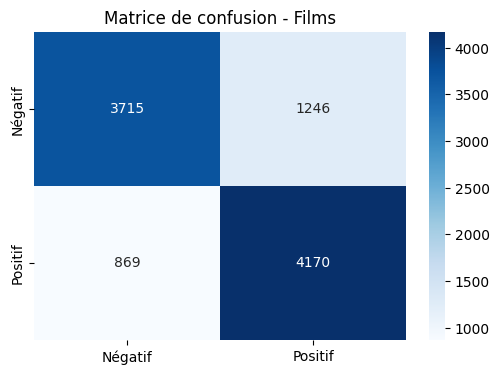

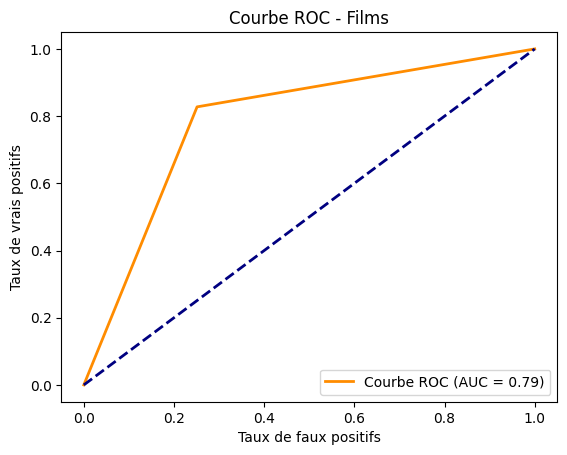

In [9]:
# Entraîner et évaluer sur le dataset de restaurants
model_rest = build_model()
history_rest = train_and_evaluate(model_rest, X_train_rest, X_test_rest, y_train_rest, y_test_rest, "Restaurants")

# Entraîner et évaluer sur le dataset de films
model_film = build_model()
history_film = train_and_evaluate(model_film, X_train_film, X_test_film, y_train_film, y_test_film, "Films")

**Visualisation des Performances**

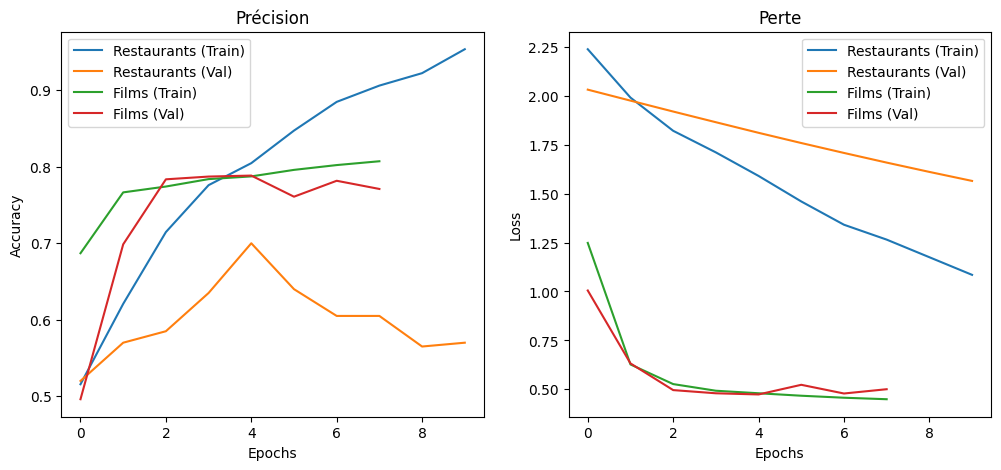

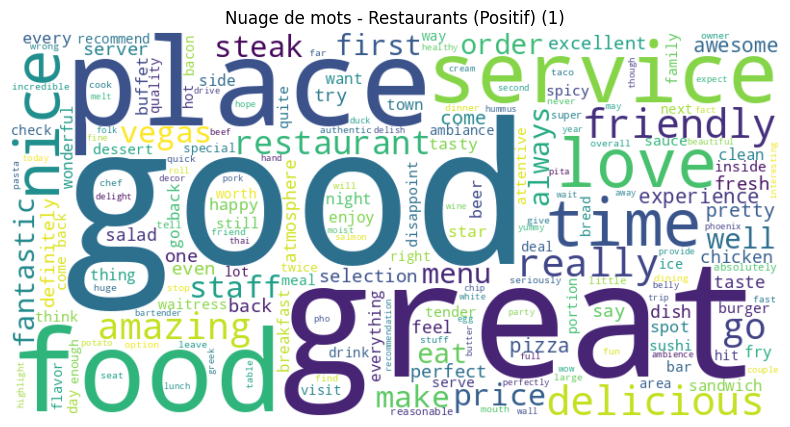

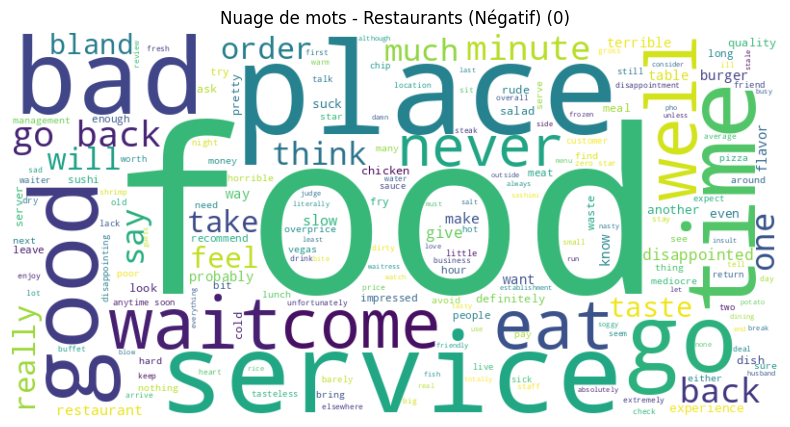

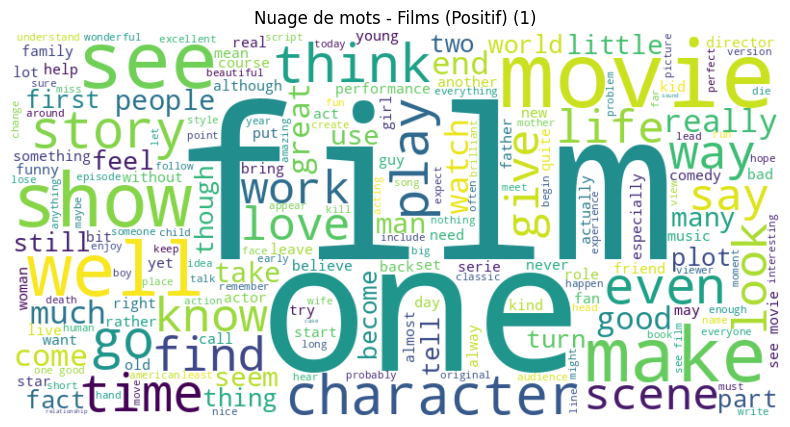

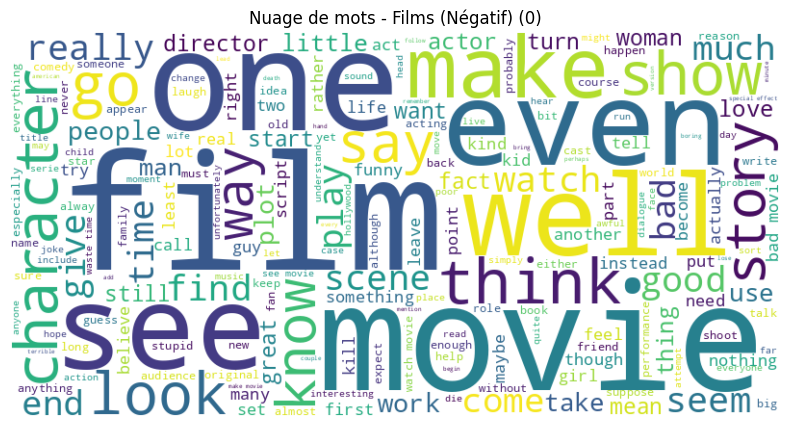

In [10]:
# Visualisation des performances
def plot_performance(history_rest, history_film):
    plt.figure(figsize=(12, 5))
    
    # Précision
    plt.subplot(1, 2, 1)
    plt.plot(history_rest.history['accuracy'], label='Restaurants (Train)')
    plt.plot(history_rest.history['val_accuracy'], label='Restaurants (Val)')
    plt.plot(history_film.history['accuracy'], label='Films (Train)')
    plt.plot(history_film.history['val_accuracy'], label='Films (Val)')
    plt.title('Précision')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Perte
    plt.subplot(1, 2, 2)
    plt.plot(history_rest.history['loss'], label='Restaurants (Train)')
    plt.plot(history_rest.history['val_loss'], label='Restaurants (Val)')
    plt.plot(history_film.history['loss'], label='Films (Train)')
    plt.plot(history_film.history['val_loss'], label='Films (Val)')
    plt.title('Perte')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Afficher les graphiques de performance
plot_performance(history_rest, history_film)

# Nuage de mots pour les critiques positives et négatives
def plot_wordcloud(data, sentiment, title):
    text = ' '.join(data[data['sentiment'] == sentiment]['review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nuage de mots - {title} ({sentiment})')
    plt.axis('off')
    plt.show()

# Nuage de mots pour les restaurants
plot_wordcloud(restaurant_data, 1, "Restaurants (Positif)")
plot_wordcloud(restaurant_data, 0, "Restaurants (Négatif)")

# Nuage de mots pour les films
plot_wordcloud(film_data, 1, "Films (Positif)")
plot_wordcloud(film_data, 0, "Films (Négatif)")